In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TensorMesh
from discretize.utils import ndgrid, mkvc

import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps, data, data_misfit as dm, inverse_problem, regularization as reglib, optimization, directives, inversion

from skimage.metrics import structural_similarity as ssim

mpl.rcParams.update({"font.size": 14})

# 可选：控制显卡
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [2]:
# Specify receiver locations and frequencies
d_station = 4 * 1e3  # distance between stations (meters)
n_rx = 26            # number of receiver stations

x0 = 50 * 1e3        # reference position for x (meters)
x = np.arange(n_rx) * d_station - x0  # x coordinates of stations, centered around x0
lx = x.max() - x.min()
rx_locs = np.c_[x, np.zeros(n_rx)]    # receiver positions in (x, z), z=0

frequencies = np.logspace(-3, 2, 20) # frequency array from 1e-3 to 1e2 Hz (20 points)
n_freq = len(frequencies)

from discretize import TensorMesh

# Calculate total range of survey line and points
all_xyz = np.vstack([*rx_locs])
x_min, x_max = all_xyz[:, 0].min(), all_xyz[:, 0].max()
z_min, z_max = -40000, 0  # vertical mesh range (can be adjusted as needed)

# Core mesh cell sizes
dx = 1000    # cell size in x (meters)
dh = 1000    # cell size in z (meters)

# Number of padding cells
pad_num = 6

# Number of core region cells
core_num_x = int(np.ceil((x_max - x_min) / dx))
core_num_z = int(np.ceil((z_max - z_min) / dh))

# Construct cell width lists for each mesh direction (x and z)
hx = [(dx, pad_num, -2.2), (dx, core_num_x), (dx, pad_num, 2.2)]
hz = [(dh, pad_num, -2), (dh, core_num_z), (dh, pad_num, 2)]

# Calculate center for x0; align horizontally at the center and put z=0 at the surface
center_x = (x_min + x_max) / 2

# Instantiate the mesh
mesh = TensorMesh([hx, hz])
x0 = [
    center_x - mesh.h[0].sum() / 2,      # center mesh horizontally
    -mesh.h[-1][:core_num_z+pad_num].sum()   # make top of mesh z=0 (surface)
]

mesh.x0 = x0

tensor_mesh = mesh
mesh


TensorMesh: 5,824 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    112   -256,029.82    256,029.82  1,000.00 113,379.90    2.20
   y     52   -166,000.00    126,000.00  1,000.00 64,000.00    2.00

In [3]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf


os.chdir('..')
loaded_model = tf.keras.models.load_model('./model_train/reg_model.h5',)
mask_model = tf.keras.models.load_model('./model_train/imaging_model.h5')




In [ ]:
# Plot: Compare inverted and true resistivity models

def transform(m):
    # Nonlinear resistivity transformation function
    return (1 + 5000 * np.exp(m)) / (1 + np.exp(m))

# Load true resistivity model and three types of inversion results
rho_true = transform(np.load('case2.npy'))
rho0 = np.load("inv_single.npy")
rho1 = np.load("inv_lci.npy")
rho2 = np.load("inv_dl.npy")

# Initialize plotting map with only active cells (below the surface)
plotting_map = maps.InjectActiveCells(mesh, mesh.cell_centers[:, -1] < 0, np.nan)

# Only apply enhancement to the central region [:, 6:-6]
active_cells = tensor_mesh.cell_centers[:, -1] < 0
nc_fine = int(np.sum(active_cells))

inversion_model_dl_reshaped = rho2[:nc_fine,].reshape(46, 112)[:, :]
strengthen_area = inversion_model_dl_reshaped[:, :]

# Only apply mask/dl to central area; border regions remain unchanged
strengthen_area_masked = loaded_model(strengthen_area[np.newaxis, :, :, np.newaxis])
strengthen_area_denoised = mask_model(strengthen_area_masked)
strengthen_area_result = np.squeeze(strengthen_area_denoised)

# Build the new result by inserting the enhanced region, retaining values at border regions
inversion_model_dl_final = inversion_model_dl_reshaped.copy()
inversion_model_dl_final[:, :] = strengthen_area_result

inversion_model_dl_mask = inversion_model_dl_final[:, :].reshape(-1,)

# Apply active cell masking to both inversion and true models
rho3 = (plotting_map * inversion_model_dl_mask)
rho_true = (plotting_map * rho_true)

rho_true.shape



(5824,)

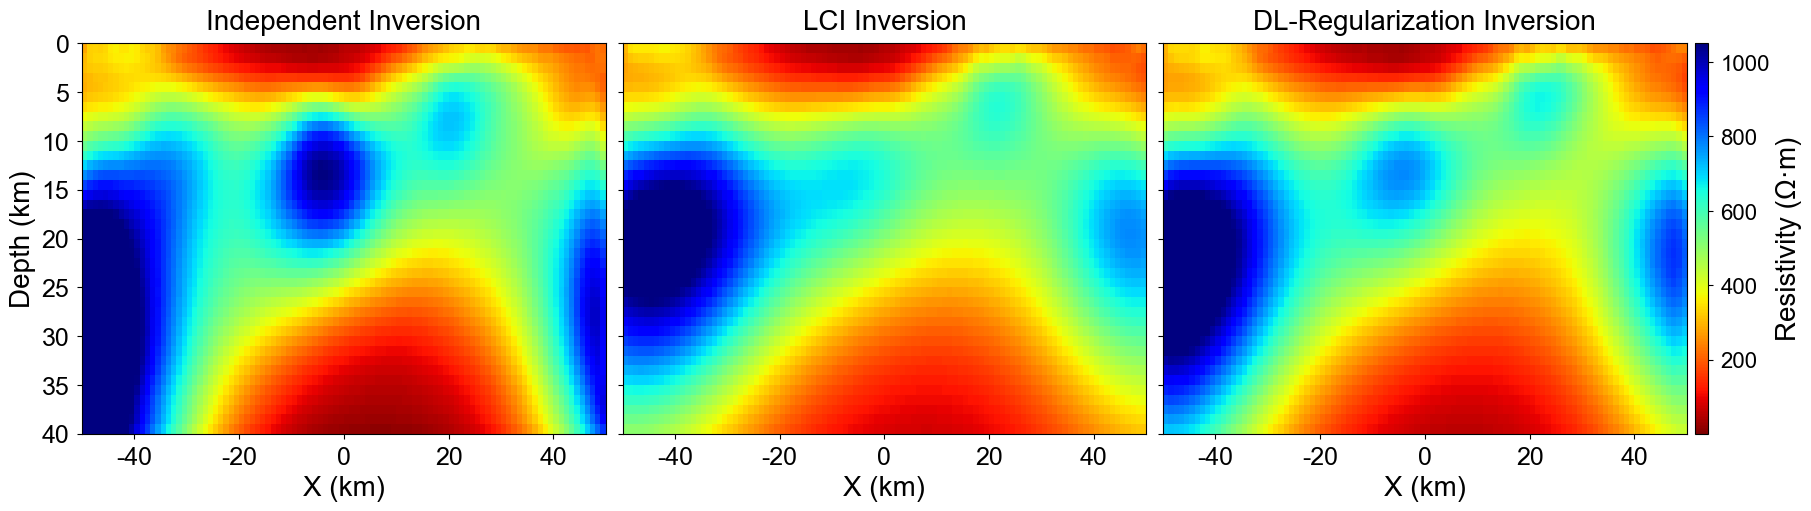

In [ ]:
import skimage.measure as measure

import matplotlib.ticker as ticker

# Use a more visually appealing plot style
plt.style.use('seaborn-v0_8-paper')

# Coordinate range (receiver locations)
y_coords = rx_locs[:, 0]

# List of resistivity models and their corresponding titles
rho_list = [rho_true, rho1, rho2]
titles = [
    "Independent Inversion", 
    "LCI Inversion", 
    "DL-Regularization Inversion", 
]

# Create a 1x3 subplot for side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True, sharey=True)

# Set unified colorbar range based on min and max values across all models
vmin = 1
vmax = 1050

vmin_cb = vmin
vmax_cb = vmax

for i, (rho, ax, title) in enumerate(zip(rho_list, axes, titles)):
    quad = tensor_mesh.plot_image(
        (rho),
        grid=False,
        pcolor_opts={'cmap': 'jet_r', 'vmin': vmin, 'vmax': vmax},
        ax=ax
    )
    ax.set_xlabel("X (km)", fontsize=20)
    if i == 0:
        ax.set_ylabel("Depth (km)", fontsize=20)
    else:
        ax.set_ylabel("", fontsize=20)
    ax.set_title(title, fontsize=20, pad=10)
    # Convert x and y axis tick labels to kilometers
    x_tick_labels_km = ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}')
    y_tick_labels_km = ticker.FuncFormatter(lambda y, pos: f'{abs(y)/1000:.0f}')
    ax.set_xlim([-50000, 50000])
    ax.set_ylim([-40000, 0])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(8))
    ax.xaxis.set_major_formatter(x_tick_labels_km)
    ax.yaxis.set_major_formatter(y_tick_labels_km)
    ax.tick_params(axis='both', which='major', labelsize=18)

# Shared colorbar for all axes in the row
cbar = fig.colorbar(quad[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.005, aspect=30)
cbar.set_label("Resistivity (Ω·m)", fontsize=20)
cbar.ax.tick_params(labelsize=16)
# Uncomment to save the figure
# fig.savefig("./result/inversion_comparison.png", dpi=400, bbox_inches='tight')

plt.show() 

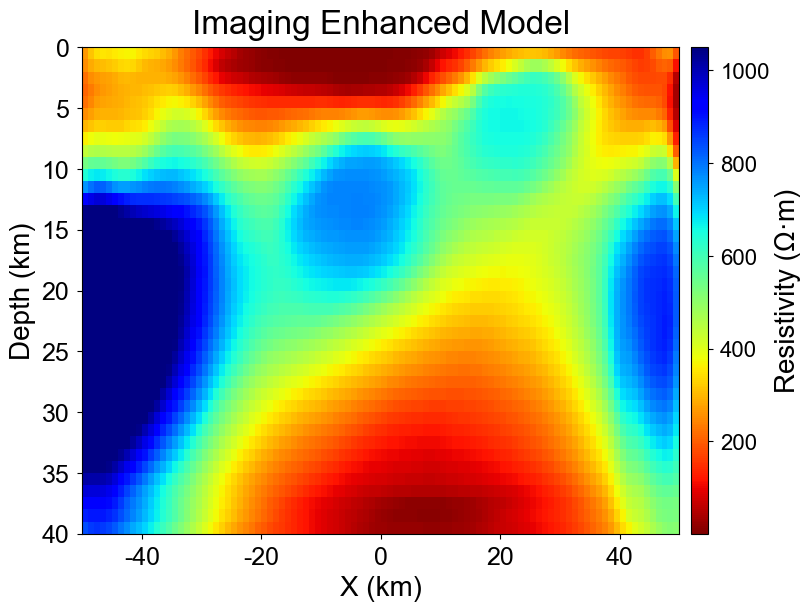

In [ ]:
# Plot only a single true model (rho_true)

import skimage.measure as measure
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# Unified colorbar value range using vmin/vmax
vmin = 1
vmax = 1050

tx_x_positions = y_coords  # Specify one transmitter at each grid point along y direction (customize as necessary)
tx_y_position = -18        # All transmitters share the same y coordinate (change as needed)
quad = tensor_mesh.plot_image(
    (rho3),
    grid=False,
    pcolor_opts={'cmap': 'jet_r', 'vmin': vmin, 'vmax': vmax},
    ax=ax
)

ax.set_xlabel("X (km)", fontsize=20)
ax.set_ylabel("Depth (km)", fontsize=20)

ax.set_title(title, fontsize=20, pad=10)
# Convert x and y ticks from meters to kilometers
x_tick_labels_km = ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}')
y_tick_labels_km = ticker.FuncFormatter(lambda y, pos: f'{abs(y)/1000:.0f}')
ax.set_xlim([-50000, 50000])
ax.set_ylim([-40000, 0])
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(8))
ax.xaxis.set_major_formatter(x_tick_labels_km)
ax.yaxis.set_major_formatter(y_tick_labels_km)
ax.tick_params(axis='both', which='major', labelsize=18)

# Add main title
ax.set_title("Imaging Enhanced Model", fontsize=24, pad=10)

# Add individual colorbar
cbar = fig.colorbar(quad[0], ax=ax, orientation='vertical', fraction=0.04, pad=0.02, aspect=30)
cbar.set_label("Resistivity (Ω·m)", fontsize=20)
cbar.ax.tick_params(labelsize=16)
# fig.savefig("./result/imaging_inversion.png", dpi=400, bbox_inches='tight')

plt.show()


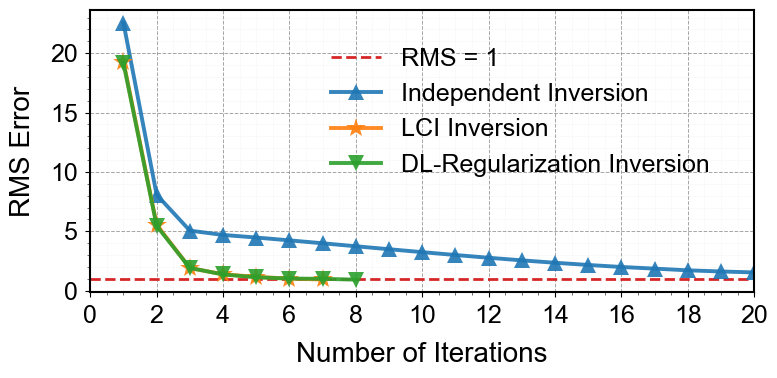

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set font (for displaying Chinese if needed, but here just set to Arial)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# Load RMS data (provide dummy data if files are missing)
RMS1 = np.load('RMS_all_single.npy')
RMS2 = np.load('RMS_all_lci.npy')
RMS3 = np.load('RMS_all_dl.npy')

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Use a professional color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot reference line
ax.axhline(y=1, color='#d62728', linestyle='--', linewidth=2, label='RMS = 1')

# Plot inversion curves
line0 = ax.plot(range(1, len(RMS1)+1), RMS1, label='Independent Inversion', linewidth=2.8, color=colors[0],
                marker='^', markersize=12, alpha=0.9)[0]

line2 = ax.plot(range(1, len(RMS2)+1), RMS2, label='LCI Inversion', linewidth=2.8, color=colors[1],
                marker='*', markersize=15, alpha=0.9)[0]
line3 = ax.plot(range(1, len(RMS3)+1), RMS3, label='DL-Regularization Inversion', linewidth=2.8, color=colors[2],
                marker='v', markersize=12, alpha=0.9)[0]

# Axis labels and title
ax.set_xlabel('Number of Iterations', fontsize=20, fontweight='medium', labelpad=10)
ax.set_ylabel('RMS Error', fontsize=20, fontweight='medium', labelpad=10)

# Legend - placed at optimal position
legend = ax.legend(fontsize=18, frameon=False, fancybox=False, shadow=False,
                  framealpha=0.95, edgecolor='black', loc='best',
                  borderpad=1, handlelength=2)

# Grid settings
ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7, color='gray')
ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5, color='lightgray')
ax.minorticks_on()

# Set axis limits
ax.set_xlim(0, int(len(RMS1)))
# ax.set_ylim(0, max(max(RMS1), max(RMS2), max(RMS3)) * 1.1)

# Set x-axis ticks (even interval, no decimals)
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

max_iter = int(len(RMS1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# Set tick label font size
ax.tick_params(axis='both', which='major', labelsize=18)

# Set axis border style
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')

# Layout adjustment
plt.tight_layout()
# plt.savefig("./对比图/RMS_Comparison.png", dpi=400, bbox_inches='tight')
# fig.savefig("./result/RMS_Comparison.png", dpi=400, bbox_inches='tight')

# Show figure
plt.show()

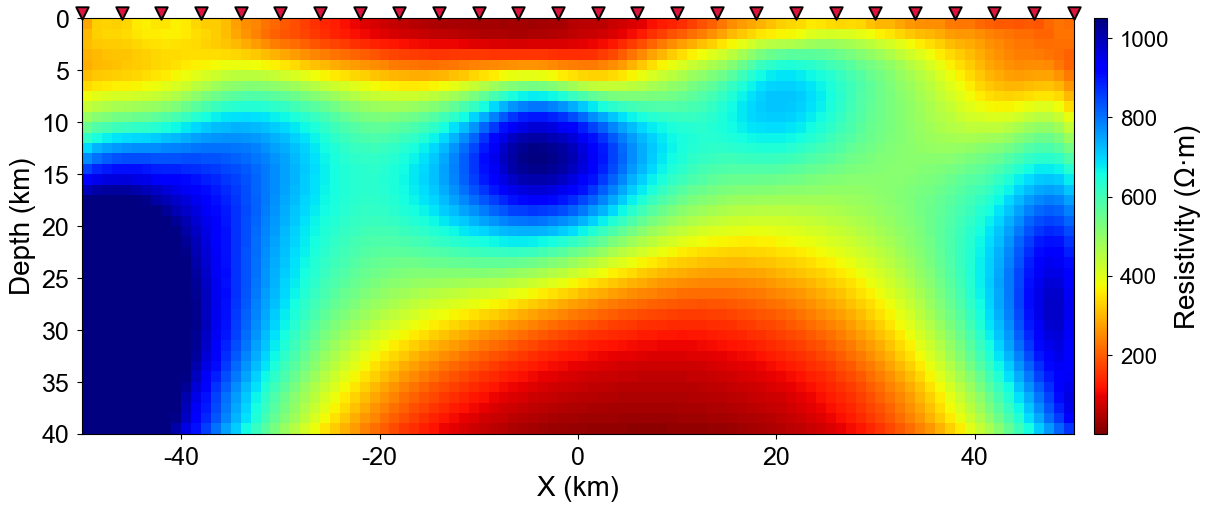

In [ ]:
# Plot only the true resistivity model (rho_true)

import skimage.measure as measure
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)

# Set the value range for the colorbar using vmin and vmax
vmin = 1
vmax = 1050

# Assign transmitter (source) positions along the y direction for each grid point
tx_x_positions = y_coords  # If you want to customize, replace this array
tx_y_position = -18  # The y-coordinate of all source points is set to -18

quad = tensor_mesh.plot_image(
    (rho_true),
    grid=False,
    pcolor_opts={'cmap': 'jet_r', 'vmin': vmin, 'vmax': vmax},
    ax=ax
)

ax.set_xlabel("X (km)", fontsize=20)
ax.set_ylabel("Depth (km)", fontsize=20)

# Convert x and y axis labels from meters to kilometers
x_tick_labels_km = ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}')
y_tick_labels_km = ticker.FuncFormatter(lambda y, pos: f'{abs(y)/1000:.0f}')
ax.set_xlim([-50000, 50000])
ax.set_ylim([-40000, 0])
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(8))
ax.xaxis.set_major_formatter(x_tick_labels_km)
ax.yaxis.set_major_formatter(y_tick_labels_km)
ax.tick_params(axis='both', which='major', labelsize=18)

# Plot observation (receiver) locations for visual effect
ax.scatter(
    rx_locs[:, 0], rx_locs[:, 1]+500,
    c='crimson', marker='v', s=80, edgecolors='k', linewidths=1.4,
    zorder=15, clip_on=False, label='Transmitter'
)

legend.get_frame().set_alpha(0.92)

# Add a separate colorbar
cbar = fig.colorbar(quad[0], ax=ax, orientation='vertical', fraction=0.04, pad=0.02, aspect=30)
cbar.set_label("Resistivity (Ω·m)", fontsize=20)
cbar.ax.tick_params(labelsize=16)
# fig.savefig("./result/model.png", dpi=400, bbox_inches='tight')

plt.show()
